In [ ]:
import pandas as pd
import os
import sys
import zipfile
from chifolio.calendar import MONTH_END, WEEK_END
from chifolio.factor import cal_ic,ic_statistic
from chifolio.measure import create_return_risk_metrics
from chifolio.backtest import Backtest
from chifolio.factor import winsorize,xsigma,xmad,adjboxplot,normalize,neutralize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")  # 忽略所有警告

# 读取数据

## 股吧数据

In [ ]:
# 从父目录获取data路径
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_path = os.path.join(os.path.join(parent_dir, 'data'),'datago')

# 打开datago数据文件
file_path = os.path.join(os.path.join(data_path,'GACRIS-V3_natural_day_basic_stat'),'GACRIS-V3_natural_day_basic_stat_20200101to20241231.csv')
natural_day_basic = pd.read_csv(file_path)

natural_day_basic['pub_date'] = pd.to_datetime(natural_day_basic['pub_date'])
natural_day_basic.rename(columns={'pub_date':'date','stock_id':'asset'}, inplace=True)
df_factor = natural_day_basic[['date','asset','senti_conform']].copy()

In [ ]:
natural_day_basic.head()

,asset,figi,date,read_neg_sum,reply_neg_sum,post_neg_sum,user_neg,user_avg_bar_age_neg,read_neu_sum,reply_neu_sum,...,user_pos,user_avg_bar_age_pos,read_all_sum,reply_all_sum,post_all_sum,user_all,user_avg_bar_age_all,senti_score_div,senti_score_log,senti_conform
0,000001.SZ,BBG000BZDPV5,2020-01-01,1436,1,2,2,913,675,2,...,4,946,5711,8,7,7,806,0.285714,0.510826,0.041685
1,000002.SZ,BBG000BZ9Z48,2020-01-01,21399,26,7,6,1241,3364,2,...,12,860,41135,46,21,19,1018,0.285714,0.559616,0.041685
2,000004.SZ,BBG000BZFT18,2020-01-01,0,0,0,0,0,361,0,...,1,273,1058,0,2,2,977,0.500000,0.693147,0.133975
3,000005.SZ,BBG000BZDNK2,2020-01-01,0,0,0,0,0,0,0,...,1,2337,744,3,1,1,2337,1.000000,0.693147,1.000000
4,000006.SZ,BBG000BZFR12,2020-01-01,1531,1,2,2,1451,0,0,...,0,0,1531,1,2,2,1451,-1.000000,-1.098610,1.000000


## 股票数据

In [ ]:
# 读取全A股价格文件
data_path = os.path.join(parent_dir, 'data')
file_path =  os.path.join(data_path, 'price_daily.h5')
df_price = pd.read_hdf(file_path, key='/data')

# 筛选2020-2024的全A价格数据
start_date='2020-01-01'
end_date='2024-12-31'
df_price_filtered = df_price.loc[start_date:end_date]

In [ ]:
df_price_filtered.head()

asset,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,001356.SZ,301602.SZ,688545.SH,001395.SZ,688411.SH,920108.BJ,302132.SZ,301173.SZ,301557.SZ,603409.SH
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,1841.6882,4832.2920,90.7460,29.1003,191.3002,79.1077,82.8549,59.0007,36.7412,34.2681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,1875.5308,4756.6019,90.8273,29.1929,194.1343,78.7764,83.7482,56.6974,36.7412,34.1960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,1863.5221,4676.4595,88.3890,29.1929,193.4257,78.5278,83.3015,62.3672,36.9567,33.8357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,1872.2557,4713.5625,89.8114,29.6563,194.4885,78.7764,84.6415,63.4302,38.1419,34.4122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,1818.7627,4701.6895,88.5109,29.1929,190.9459,77.8652,83.0782,62.9873,37.8187,33.4753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 分歧因子月频测试

## 全A

In [ ]:
# 缩小日期范围
end_dates = pd.DatetimeIndex(MONTH_END)
min_date = natural_day_basic['date'].min()
max_date = natural_day_basic['date'].max()
relevant_end_dates = end_dates[(end_dates >= min_date) & (end_dates <= max_date)]

In [ ]:
def ic_table(factors, descriptor, df_price, date_list,universe=None):
    results = []
    for f in factors:
        series = ic_statistic(cal_ic(descriptor[f], df_price, date_list, block=universe))
        series.name = f
        results.append(series)
    return pd.DataFrame(results)

In [ ]:
# 存储最终的聚合结果
result_list = []
lookback_days = 20
min_days = 10
trading_dates = df_price_filtered.index

# 遍历每个调仓日
for end_date in relevant_end_dates:

    # 找到 end_date 之前的 lookback_days 个交易日
    trading_days_before_end = trading_dates[trading_dates < end_date][-lookback_days:]
    start_date = trading_days_before_end[0] 


    # 筛选 df_factors 中日期在 [start_date, end_date] 区间内的数据
    lookback_df = natural_day_basic[(natural_day_basic['date'] >= start_date) & (natural_day_basic['date'] < end_date)]

    # 统计每个股票在这段时间的有效天数
    news_days = lookback_df.groupby("asset")["senti_conform"].count()

    # 筛出满足 min_days 要求的 asset
    qualified_assets = news_days[news_days >= min_days].index
    
    # 计算所需的统计指标
    group_factors = lookback_df.groupby('asset').agg(
        senti_score_div=('senti_score_div', 'mean'),  
        senti_score_log=('senti_score_log', 'mean'),  
        senti_conform=('senti_conform', 'mean')  
    ).reset_index()
    
    # 只保留满足覆盖率条件的资产
    group_factors = group_factors[group_factors['asset'].isin(qualified_assets)]
    
    # 添加调仓日列，方便后续对齐
    group_factors['date'] = end_date

    # 存入结果列表
    result_list.append(group_factors)

# 合并所有结果
df_final = pd.concat(result_list, ignore_index=True)

In [ ]:
descriptor_month = df_final.copy()
descriptor_month.set_index(['date','asset'],inplace=True)
descriptor_month = descriptor_month.sort_index()

factors = ['senti_score_div','senti_score_log','senti_conform']
ic_results_monthly_a = ic_table(factors, descriptor_month, df_price_filtered, MONTH_END)

In [ ]:
ic_results_monthly_a

,IC,ICSTD,IR,T
senti_score_div,-0.013955,0.083854,-0.166420,-1.278298
senti_score_log,-0.005529,0.091044,-0.060725,-0.466438
senti_conform,0.062876,0.097771,0.643091,4.939676


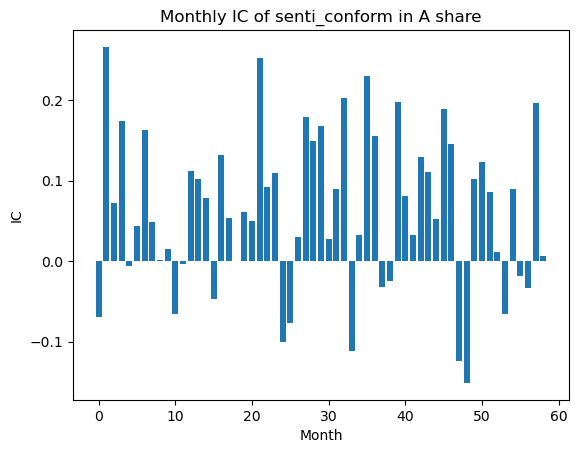

In [ ]:
ic_monthly_a_senti_conform = cal_ic(descriptor_month['senti_conform'], df_price_filtered, MONTH_END)
plt.bar(range(len(ic_monthly_a_senti_conform)), ic_monthly_a_senti_conform)
# plt.bar(ic_weekly_a_senti_conform.index, ic_weekly_a_senti_conform)
# 添加标题和标签
plt.title('Monthly IC of senti_conform in A share')
plt.xlabel('Month')
plt.ylabel('IC')

# 显示图表
plt.show()

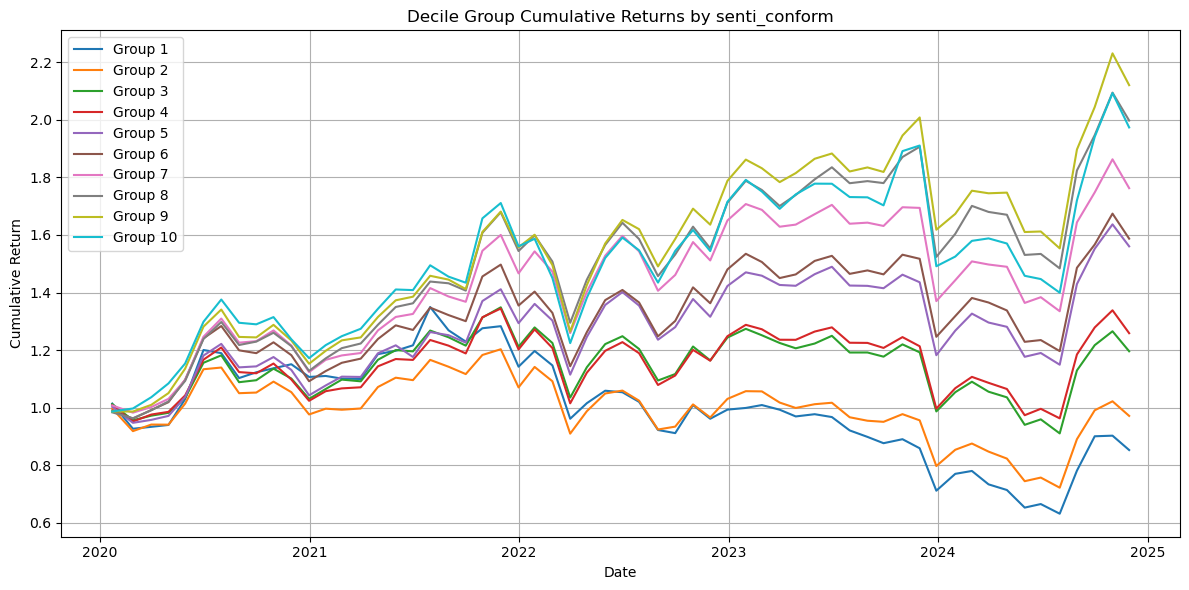

In [ ]:
# 初始化
quantile_returns = {i: [] for i in range(10)}
rebalance_dates = descriptor_month.index.levels[0].intersection(df_price_filtered.index)

# 重采样生成月收益率
monthly_returns = df_price_filtered.reindex(rebalance_dates).pct_change().shift(-1)

# 遍历每个调仓日
for date in rebalance_dates[:-1]:
    try:
        current_factor = descriptor_month.loc[date, 'senti_conform']
        valid_data = current_factor.loc[current_factor.index.intersection(monthly_returns.columns)]

        # 分成10组
        deciles = pd.qcut(valid_data, q=10, labels=False)
        for i in range(10):
            group_stocks = deciles[deciles == i].index
            group_return = monthly_returns.loc[date, group_stocks].mean()
            quantile_returns[i].append(group_return)
    except Exception as e:
        print(f"{date} 失败：{e}")
        for i in range(10):
            quantile_returns[i].append(None)

# 转为 DataFrame，行为时间，列为分组
quantile_return_df = pd.DataFrame(quantile_returns, index=rebalance_dates[:-1])

# 累计净值
quantile_cumret_df = (1 + quantile_return_df.fillna(0)).cumprod()

# 画图
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(quantile_cumret_df.index, quantile_cumret_df[i], label=f'Group {i+1}')
plt.title('Decile Group Cumulative Returns by senti_conform')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

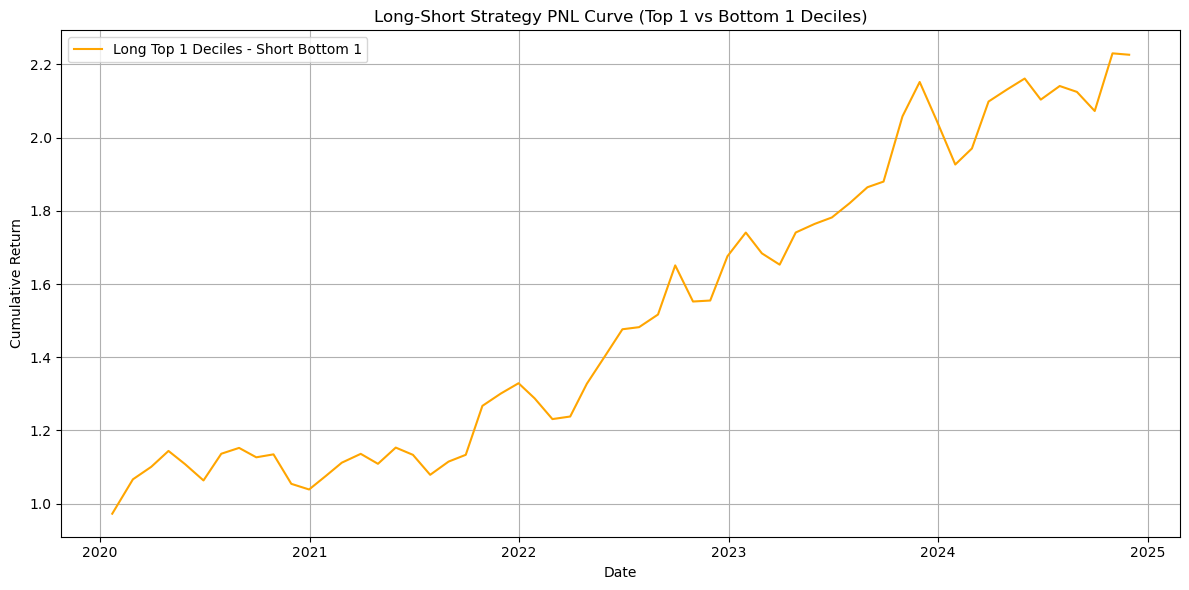

Annual Return        0.1768
Annual Volatility    0.1484
Information Ratio    1.1912
Max Drawdown         0.2255
Win Rate             0.6610
dtype: float64


In [ ]:
# 提取可用数据的交集
common_stocks = descriptor_month.index.get_level_values(1).intersection(df_price_filtered.columns)
descriptor_month = descriptor_month[descriptor_month.index.get_level_values(1).isin(common_stocks)]
rebalance_dates = descriptor_month.index.levels[0].intersection(df_price_filtered.index)

# 生成月度收益率：用月末价格计算下月涨跌幅
monthly_returns = df_price_filtered[common_stocks].reindex(rebalance_dates).pct_change().shift(-1)

# 初始化空的收益序列
portfolio_returns = pd.Series(index=rebalance_dates[:-1], name='LongShort_Return', dtype=float)

# 回测：每期做多top2组，做空bottom2组
for date in rebalance_dates[:-1]:
    try:
        current_factor = descriptor_month.loc[date, 'senti_conform']
        valid_data = current_factor.loc[current_factor.index.intersection(monthly_returns.columns)]

        # 分为10组
        deciles = pd.qcut(valid_data, q=10, labels=False)

        # 做多第9组和第10组（label是8和9），做空第1和第2组（label是0和1）
        long_stocks = deciles[deciles.isin([9])].index
        short_stocks = deciles[deciles.isin([0])].index

        # 对应收益
        long_ret = monthly_returns.loc[date, long_stocks].mean()
        short_ret = monthly_returns.loc[date, short_stocks].mean()

        # 多空组合收益
        portfolio_returns.loc[date] = long_ret - short_ret
    except Exception as e:
        print(f"{date} 回测失败: {e}")
        continue

# 计算累计净值
cum_ret = (1 + portfolio_returns.dropna()).cumprod()

# 📈 绘制 PNL 曲线
plt.figure(figsize=(12, 6))
plt.plot(cum_ret.index, cum_ret.values, label='Long Top 1 Deciles - Short Bottom 1', color='orange')
plt.title('Long-Short Strategy PNL Curve (Top 1 vs Bottom 1 Deciles)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📊 计算绩效指标
def compute_metrics(returns):
    ann_ret = (1 + returns).prod() ** (12 / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(12)
    ir = ann_ret / ann_vol if ann_vol != 0 else np.nan
    max_dd = ((1 + returns).cumprod().cummax() - (1 + returns).cumprod()).max()
    win_rate = (returns > 0).mean()
    return pd.Series({
        'Annual Return': ann_ret,
        'Annual Volatility': ann_vol,
        'Information Ratio': ir,
        'Max Drawdown': max_dd,
        'Win Rate': win_rate
    })

perf = compute_metrics(portfolio_returns.dropna())
print(perf.round(4))


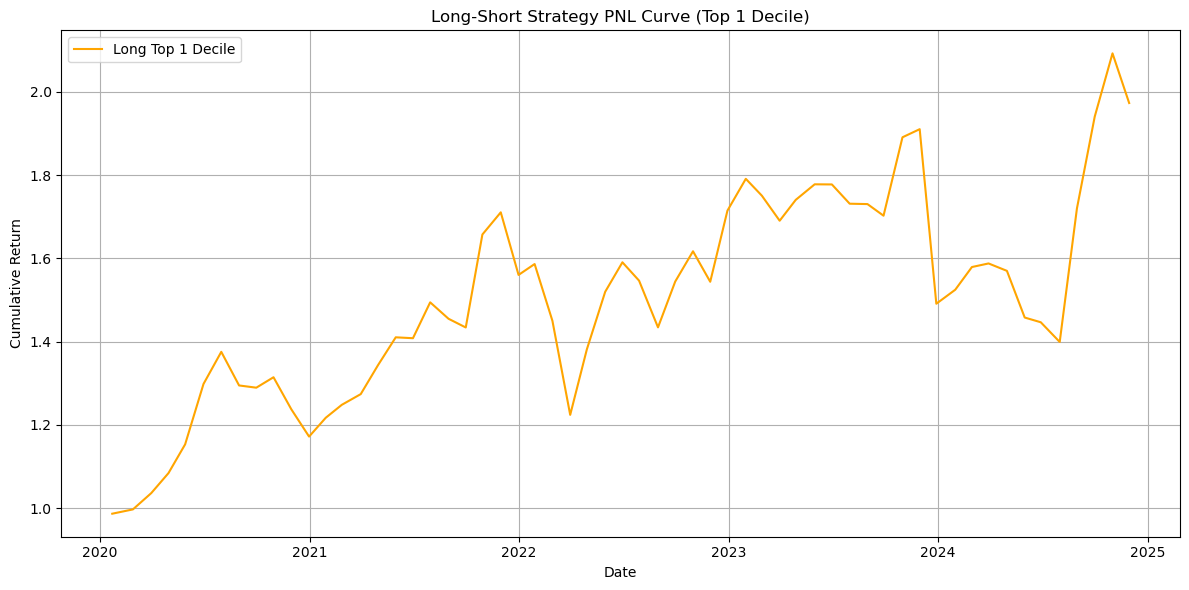

Annual Return        0.1483
Annual Volatility    0.2546
Information Ratio    0.5825
Max Drawdown         0.5111
Win Rate             0.5593
dtype: float64


In [ ]:
# 提取可用数据的交集
common_stocks = descriptor_month.index.get_level_values(1).intersection(df_price_filtered.columns)
descriptor_month = descriptor_month[descriptor_month.index.get_level_values(1).isin(common_stocks)]
rebalance_dates = descriptor_month.index.levels[0].intersection(df_price_filtered.index)

# 生成月度收益率：用月末价格计算下月涨跌幅
monthly_returns = df_price_filtered[common_stocks].reindex(rebalance_dates).pct_change().shift(-1)

# 初始化空的收益序列
portfolio_returns = pd.Series(index=rebalance_dates[:-1], name='LongShort_Return', dtype=float)

# 回测：每期做多top2组，做空bottom2组
for date in rebalance_dates[:-1]:
    try:
        current_factor = descriptor_month.loc[date, 'senti_conform']
        valid_data = current_factor.loc[current_factor.index.intersection(monthly_returns.columns)]

        # 分为10组
        deciles = pd.qcut(valid_data, q=10, labels=False)

        # 做多第9组和第10组（label是8和9），做空第1和第2组（label是0和1）
        long_stocks = deciles[deciles.isin([9])].index
#         short_stocks = deciles[deciles.isin([0,1,2,3,4,5])].index

        # 对应收益
        long_ret = monthly_returns.loc[date, long_stocks].mean()
#         short_ret = monthly_returns.loc[date, short_stocks].mean()

        # 多空组合收益
        portfolio_returns.loc[date] = long_ret
    except Exception as e:
        print(f"{date} 回测失败: {e}")
        continue

# 计算累计净值
cum_ret = (1 + portfolio_returns.dropna()).cumprod()

# 📈 绘制 PNL 曲线
plt.figure(figsize=(12, 6))
plt.plot(cum_ret.index, cum_ret.values, label='Long Top 1 Decile', color='orange')
plt.title('Long-Short Strategy PNL Curve (Top 1 Decile)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📊 计算绩效指标
def compute_metrics(returns):
    ann_ret = (1 + returns).prod() ** (12 / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(12)
    ir = ann_ret / ann_vol if ann_vol != 0 else np.nan
    max_dd = ((1 + returns).cumprod().cummax() - (1 + returns).cumprod()).max()
    win_rate = (returns > 0).mean()
    return pd.Series({
        'Annual Return': ann_ret,
        'Annual Volatility': ann_vol,
        'Information Ratio': ir,
        'Max Drawdown': max_dd,
        'Win Rate': win_rate
    })

perf = compute_metrics(portfolio_returns.dropna())
print(perf.round(4))

In [ ]:
senti_conform_result = descriptor_month['senti_conform'].copy()
# senti_conform_result = backtester.descriptor_all[backtester.param['factor']].copy() # 这个有问题

# 存储等权 portfolio 的结果
portfolio = {}

# 遍历每个月的因子值，取 top 20%（q=8,9）
for date, group in senti_conform_result.groupby(level=0):
    try:
        # 去掉缺失值
        valid_group = group.dropna()
        if len(valid_group) < 10:  # 避免样本太小导致 qcut 报错
            continue

        # 分位分组
        quantiles = pd.qcut(valid_group, q=10, labels=False)
        top10 = quantiles[(quantiles == 9)].index

        num_stocks = len(top10)
        weights = pd.Series(1 / num_stocks, index=top10, name='weight')
        portfolio[date] = weights
    except Exception as e:
        print(f"{date} 处理失败：{e}")
        continue

        # 缩小日期范围
month_end_dates = pd.DatetimeIndex(MONTH_END)
min_date = df_price_filtered.index.min()
max_date = df_price_filtered.index.max()
relevant_month_ends = month_end_dates[(month_end_dates >= min_date) & (month_end_dates <= max_date)]

# 股票收益（先验数据）
stocks_rets = df_price_filtered.pct_change().fillna(0)

# Backtest
ret_portfolio = Backtest(stocks_rets, portfolio, cost=0.0015).run()

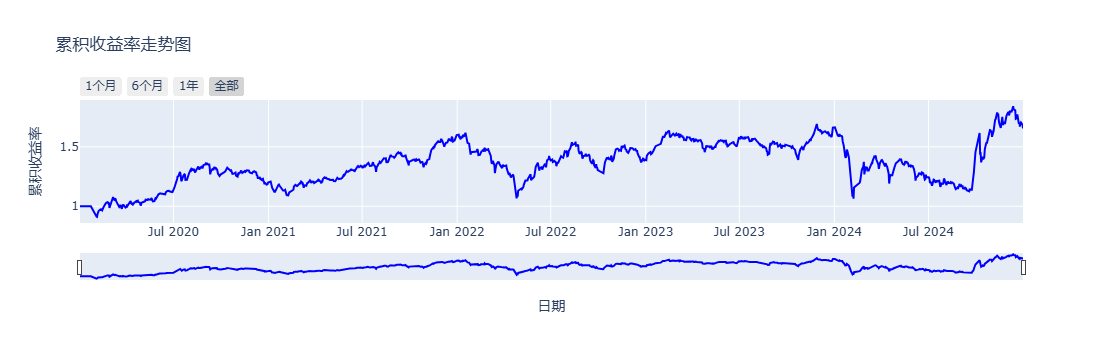

In [ ]:
# 假设ret_portfolio是你的累积收益率Series，索引是日期
# 创建图形
fig = go.Figure()

# 添加累积收益率线
fig.add_trace(
    go.Scatter(
        x=ret_portfolio.index,
        y=ret_portfolio.values,
        mode='lines',
        name='累积收益率',
        line=dict(color='blue', width=2)
    )
)

# 设置图形布局
fig.update_layout(
    title='累积收益率走势图',
    xaxis_title='日期',
    yaxis_title='累积收益率',
    hovermode='x unified',
    
    # 以下设置增强了交互性
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1个月", step="month", stepmode="backward"),
                dict(count=6, label="6个月", step="month", stepmode="backward"),
                dict(count=1, label="1年", step="year", stepmode="backward"),
                dict(count=1, label="全部", step="all")
            ])
        ),
        rangeslider=dict(visible=True),  # 显示范围滑块
        type="date"
    ),
    
    # y轴自动缩放
    yaxis=dict(fixedrange=False)
)

# 显示图形
fig.show()

In [ ]:
create_return_risk_metrics(ret_portfolio.pct_change(), period='daily')

annual_return        11.04%
annual_volatility    25.36%
sharpe_ratio           0.54
max_drawdown         37.15%
omega_ratio           -1.11
calmar_ratio           0.37
sortino_ratio          0.75
dtype: object